In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
# Getting a list of files in raw data folder
filenames = os.listdir('./processed_data/')

In [3]:
# Commented out the unused features
header_wanted = [
 'HOURLYVISIBILITY',
 'HOURLYDRYBULBTEMPC',
 'HOURLYWETBULBTEMPC',
 'HOURLYDewPointTempC',
 'HOURLYRelativeHumidity',
 'HOURLYWindSpeed',
 #'HOURLYWindGustSpeed',
 'HOURLYStationPressure',
 #'HOURLYPressureTendency',
 #'HOURLYPressureChange',
 #'HOURLYSeaLevelPressure',
 #'HOURLYPrecip',
 #'HOURLYAltimeterSetting'
]

In [4]:
usecols = ['DATE','STATION'] + header_wanted

In [5]:
# Loading all files into a pandas Dataframe and normalizing data to between 0 and 1
tqdm.pandas()
df = pd.concat([pd.read_csv('./processed_data/{}'.format(x), usecols=usecols, low_memory=False) for x in tqdm(filenames)])
df[header_wanted] = (df[header_wanted] - df[header_wanted].min()) / (df[header_wanted].max() - df[header_wanted].min())

100%|████████████████████████████████████████████████████████████████████████████████| 372/372 [00:35<00:00, 10.53it/s]


At this point all the data has been loaded into a single dataframe and any data changes have been made. The next step is to break the data up by WBAN and place in a 2D array at the appropriate grid cell. 

In [6]:
stations = pd.read_csv("./stations_mask.csv", usecols = ['STATION_ID', 'LON_SCALED', 'LAT_SCALED'])

In [7]:
height = 20
width = 40
depth = 24 * 365 * 2

In [8]:
mask = [([0] * width) for i in range(height)]

wban_loc = dict(zip(stations.STATION_ID,zip(stations.LON_SCALED,stations.LAT_SCALED)))

In [9]:
grid = [([pd.DataFrame()] * width) for i in range(height)]

In [10]:
# Making a mask while also placing appropriate data frames in their final location
for key, value in tqdm(wban_loc.items()):
    mask[value[1]][value[0]] = 1
    grid[value[1]][value[0]] = df.loc[df.STATION == key]

100%|████████████████████████████████████████████████████████████████████████████████| 372/372 [03:51<00:00,  1.61it/s]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

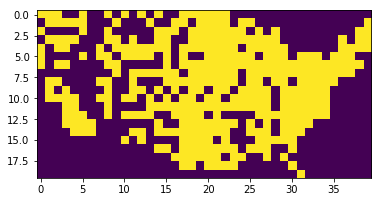

In [12]:
plt.imshow(mask)

In [13]:
# Loops through every record and slices off a single record for each pixel to make a single frame and then exports
# an array of frames
def create_frames(data,height, width, depth):
    days = []
    frames = []
    for i in tqdm(range(depth)):
        frame = np.zeros((height,width,7))
        frame[:,:,:] = np.nan
        for y in range(height):
            for x in range(width):
                if(not data[y][x].empty):
                    frame[y][x] = data[y][x].iloc[[i],1:8].values.flatten()
        if((i+1)%24 != 0):
            frames.append(frame)
        else:
            frames.append(frame)
            days.append(frames)
            frames = []
    return np.array(days)

In [15]:
# Returns an array of neighbors to be used in average_grid
def get_neighbors(x,y,g):
    neighbors = []
    for i in [y-1,y,y+1]:
        for j in [x-1,x,x+1]:
            if(i >= 0 and j >= 0):
                if(i != y or j != x ):
                    try:
                        neighbors.append(g[i][j])
                    except:
                        pass
    return np.array(neighbors)

In [16]:
# Merges the average frame with the true data frame to create an averaged frame
def merge_frames(average, mask, data, height, width):
    for i in range(height):
        for j in range(width):
            if(mask[i][j] != 1):
                data[i][j] = average[i][j]

In [14]:
# Takes a frame and then computes and average based on neighbor pixels without causing data drift
def average_grid(mask,data, height, width):
    temp_frame = [([0] * width) for i in range(height)]
    for i in range(height):
        for j in range(width):
            if(mask[i][j] != 1):
                neighbors = get_neighbors(j,i,data)
                temp_frame[i][j] = np.nanmean(neighbors, axis=0)
    merge_frames(temp_frame, mask, data, height, width)

In [17]:
# Used to break frames into training, validation, and testing sets and store them in hickle files along with the
# sources for each set
def store_sequence(frames):
    import hickle as hkl
    train_frames = []
    train_sources = []
    validation_frames = []
    validation_sources = []
    test_frames = []
    test_sources = []
    
    for day in range(len(frames)):
        for hour in range(len(frames[day])):
            if(day/len(frames) < .6):
                train_sources.append("{}".format(day))
                train_frames.append(frames[day][hour])
            elif(day/len(frames) >= .6 and day/len(frames) < .8):
                validation_sources.append("{}".format(day))
                validation_frames.append(frames[day][hour])
            else:
                test_sources.append("{}".format(day))
                test_frames.append(frames[day][hour])
    
    print("There are {} frames and {} sources in training set".format(len(train_frames), len(train_sources)))
    print("There are {} frames and {} sources in validation set".format(len(validation_frames), len(validation_sources)))
    print("There are {} frames and {} sources in testing set".format(len(test_frames), len(test_sources)))
    
    hkl.dump(np.array(train_frames), '../data/x_train.hkl')
    hkl.dump(train_sources, '../data/sources_train.hkl')
    hkl.dump(np.array(validation_frames), '../data/x_val.hkl')
    hkl.dump(validation_sources, '../data/sources_val.hkl')
    hkl.dump(np.array(test_frames), '../data/x_test.hkl')
    hkl.dump(test_sources, '../data/sources_test.hkl')
            

In [18]:
frames = create_frames(grid, height, width,depth)

100%|██████████████████████████████████████████████████████████████████████████| 17520/17520 [1:12:35<00:00,  4.02it/s]


In [1]:
# Plotting the newly made frame
fig=plt.figure(figsize=(15,10))
columns = 3
rows = 4
for i in range(1,columns+rows +1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(frames[0,0,:,:,i-1])
    plt.ylabel(header_wanted[i-1], fontsize=10)


NameError: name 'plt' is not defined

In [22]:
# Loop used to go over each frame and have it averaged
for x in tqdm(range(len(frames))):
    for y in range(len(frames[0])):
        average_grid(mask, frames[x][y], height, width )

  0%|                                                                                          | 0/730 [00:00<?, ?it/s]c:\users\dasputer\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [13:47<00:00,  1.13s/it]


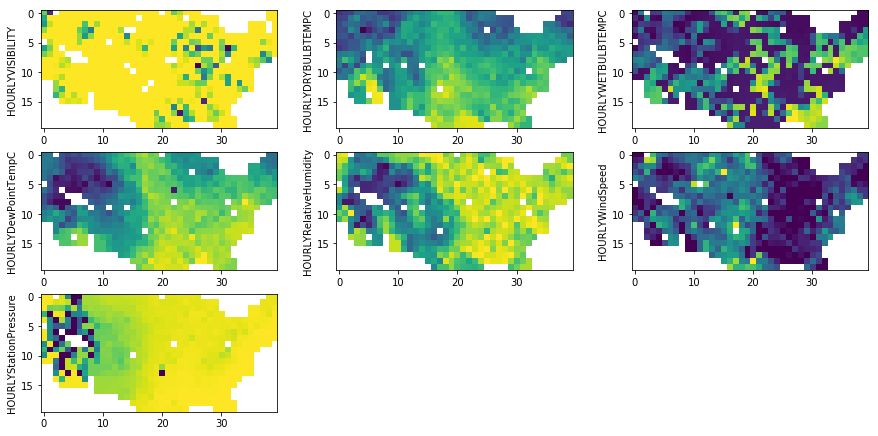

In [23]:
# Plotting a newly averaged frame
fig=plt.figure(figsize=(15,10))
columns = 3
rows = 4
for i in range(1,columns+rows +1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(frames[0,0,:,:,i-1])
    plt.ylabel(header_wanted[i-1], fontsize=10)

In [ ]:
frames.shape

In [24]:
store_sequence(frames)

There are 10512 frames and 10512 sources in training set
There are 3504 frames and 3504 sources in validation set
There are 3504 frames and 3504 sources in testing set


At this point the data has been processed and made into discrete frames and it is time to run it through the PredNet architecture for training.